In [1]:
%pip install pandas numpy seaborn matplotlib scikit-learn xgboost catboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import pickle as pkl

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler as Scaler
# import hyperopt

from models import decision_tree, k_nearest, logistic_regression, random_forest, support_vector_cls, xgboost

In [4]:
csv_file_names = ["pyradiomics_extraction_box_with_correct_mask.csv", "pyradiomics_extraction_box_without_correct_mask.csv", 
             "pyradiomics_extraction_segmentation_maskcorrect.csv", "pyradiomics_extraction_segmentation_no_maskcorrect.csv"]

FILE_INDEX = 3
FILENAME = csv_file_names[FILE_INDEX].split('.')[0] +  '_with_preprocessing'
RESULTS_PATH = f'Results_DemoGraphics/{FILENAME}.csv'

CLASS_LABELS = '../../Data/Patient class labels.csv'
DF_PATH = '../../Data/With Demographic Features/' + csv_file_names[FILE_INDEX]
MODEL_PICKLING = f'Results_DemoGraphics/{FILENAME}.pkl'

In [5]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.15
TEST_RATIO = 0.25

SEED = 2454259

CRITERION = 'accuracy'

In [6]:
labels = pd.read_csv(CLASS_LABELS)
features = pd.read_csv(DF_PATH).drop(columns = 'sequence', errors='ignore')
total_features = pd.merge(features, labels, left_on = 'patient', right_on = 'Patient ID').drop(columns = ['Patient ID', 'patient'])
total_features

original_shape_Elongation  original_shape_Flatness  \
0                     0.807005                 0.729780   
1                     0.641558                 0.577887   
2                     0.756223                 0.272616   
3                     0.718139                 0.610317   
4                     0.687760                 0.436019   
..                         ...                      ...   
917                   0.886914                 0.668151   
918                   0.757419                 0.596730   
919                   0.872632                 0.837806   
920                   0.855874                 0.735409   
921                   0.896751                 0.767845   

     original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                         23.614309                       32.358102   
1                         17.378564                       30.072592   
2                         13.050754                       47.872295   
3                          8.730117                       14.304230   
4                         22.539193                       51.693090   
..                              ...                             ...   
917                       28.553043                       42.734408   
918                       12.864613                       21.558522   
919                       15.199560                       18.142097   
920                       30.453436                       41.410193   
921                        9.406096                       12.249994   

     original_shape_Maximum2DDiameterColumn  \
0                                 36.073737   
1                                 23.148662   
2                                 40.488107   
3                                 11.420813   
4                                 55.175581   
..                                      ...   
917                               45.886501   
918                               21.066007   
919                               19.038279   
920                               43.076382   
921                               14.031840   

     original_shape_Maximum2DDiameterRow  \
0                              38.431136   
1                              29.852205   
2                              43.126056   
3                              14.972284   
4                              49.674566   
..                                   ...   
917                            41.977361   
918                            20.543932   
919                            20.649190   
920                            45.448460   
921                            12.641847   

     original_shape_Maximum2DDiameterSlice  original_shape_Maximum3DDiameter  \
0                                39.309346                         45.798426   
1                                29.748492                         33.784677   
2                                56.606869                         57.665740   
3                                14.477716                         16.540987   
4                                36.443449                         58.274413   
..                                     ...                               ...   
917                              51.383808                         56.016573   
918                              25.375225                         27.268354   
919                              20.505122                         24.348411   
920                              48.143552                         54.398662   
921                              13.078416                         16.022136   

     original_shape_MeshVolume  original_shape_MinorAxisLength  ...  \
0                 11352.720350                       26.113156  ...   
1                  4051.005400                       19.293327  ...   
2                 11866.396190                       36.202150  ...   
3                   829.333325                       10.272429  ...   
4                 25572.814940   

## Train test split

In [7]:
def train_test_val_splits(df, train_ratio = 0.8, val_ratio = 0.2, random_state = 2454259):
   
    val_ratio_adj = val_ratio / (1-train_ratio)

    train_df, val_df = train_test_split(df, train_size = train_ratio, random_state= random_state)
    val_df, test_df = train_test_split(val_df, train_size = val_ratio_adj, random_state= random_state)

    return train_df, val_df, test_df

train_df, val_df, test_df = train_test_val_splits(total_features, TRAIN_RATIO, VAL_RATIO, random_state = SEED)

Feature scaling - on all three datasets;    
Feature Engineering - on training+validation only;      
Resampling - on training only

### Feature Engineering

In [8]:
# Performing automated feature selection using XGBoost
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

def feature_selection_xgboost(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    model = XGBClassifier()
    model.fit(X, y)
    # print(model.feature_importances_)

    selection = SelectFromModel(model, threshold=0.01, prefit=True)
    clf = selection.transform(X)
    selected_features_XGBoost = pd.DataFrame(clf)
    selected_features_XGBoost.columns = X.columns[selection.get_support()]
    # print("Dropped Features - ")
    # print(X.columns[~selection.get_support()])

    # adding last column back to the dataframe
    selected_features_XGBoost[df.columns[-1]] = [i for i in df.iloc[:,-1]]
    return selected_features_XGBoost


selected_features_XGBoost_ = feature_selection_xgboost(train_df)
selected_features_XGBoost_


# X = train_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype'])
# y = train_df['ER']
# model = XGBClassifier()
# model.fit(X, y)
# # print(model.feature_importances_)

# selection = SelectFromModel(model, threshold=0.01, prefit=True)
# clf = selection.transform(X)
# selected_features_XGBoost = pd.DataFrame(clf)
# selected_features_XGBoost.columns = X.columns[selection.get_support()]
# print("Dropped Features - ")
# print(X.columns[~selection.get_support()])

# selected_features_XGBoost['ER'] = [i for i in clean_df['ER']]
# selected_features_XGBoost['PR'] = [i for i in clean_df['PR']]
# selected_features_XGBoost['HER2'] = [i for i in clean_df['HER2']]
# selected_features_XGBoost['Mol Subtype'] = [i for i in clean_df['Mol Subtype']]
# selected_features_XGBoost

/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


original_firstorder_10Percentile   ER   PR  HER2  Mol Subtype
0                            0.912937  0.0  0.0   0.0            3
1                            0.920617  1.0  1.0   0.0            0
2                            1.077708  1.0  1.0   1.0            1
3                            0.817995  0.0  0.0   0.0            3
4                            1.579355  1.0  1.0   0.0            0
..                                ...  ...  ...   ...          ...
548                          2.316632  1.0  1.0   0.0            0
549                          0.586390  1.0  0.0   0.0            0
550                          1.967681  1.0  0.0   0.0            0
551                          0.667242  1.0  1.0   0.0            0
552                          1.332955  1.0  1.0   0.0            0

[553 rows x 5 columns]

## Resampling

### Imbalanced Data

In [9]:
# splitting the dataset for training, testing, validating on ER subtype
train_x_er, train_y_er = train_df.drop(columns = ['ER']), train_df['ER']
val_x_er, val_y_er = val_df.drop(columns = ['ER']), val_df['ER']
test_x_er, test_y_er = test_df.drop(columns = ['ER']), test_df['ER']

# splitting the dataset for training, testing, validating on PR subtyp
train_x_pr, train_y_pr = train_df.drop(columns = ['PR']), train_df['PR']
val_x_pr, val_y_pr = val_df.drop(columns = ['PR']), val_df['PR']
test_x_pr, test_y_pr = test_df.drop(columns = ['PR']), test_df['PR']

# splitting the dataset for training, testing, validating on HER2 subtype
train_x_her2, train_y_her2 = train_df.drop(columns = ['HER2']), train_df['HER2']
val_x_her2, val_y_her2 = val_df.drop(columns = ['HER2']), val_df['HER2']
test_x_her2, test_y_her2 = test_df.drop(columns = ['HER2']), test_df['HER2']

# splitting the dataset for training, testing, validating on molecular subtype
train_x_mol_subtype, train_y_mol_subtype = train_df.drop(columns = ['Mol Subtype']), train_df['Mol Subtype']
val_x_mol_subtype, val_y_mol_subtype = val_df.drop(columns = ['Mol Subtype']), val_df['Mol Subtype']
test_x_mol_subtype, test_y_mol_subtype = test_df.drop(columns = ['Mol Subtype']), test_df['Mol Subtype']

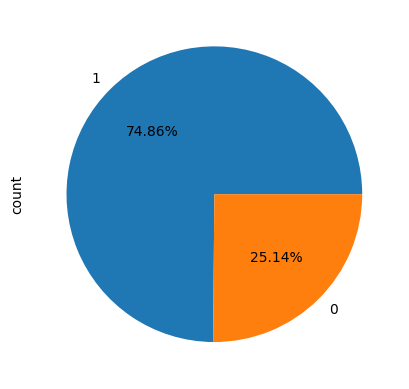

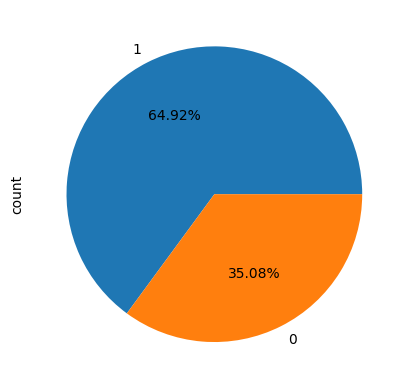

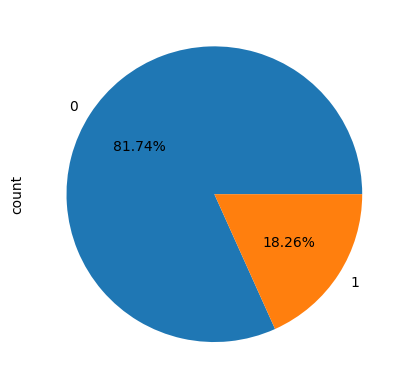

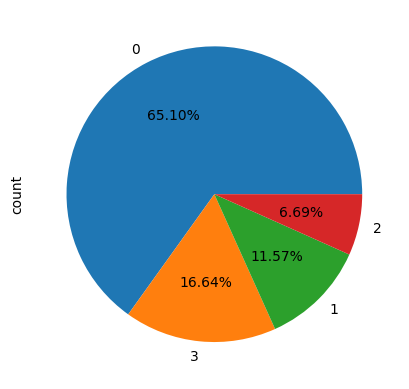

In [10]:
train_df['ER'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['PR'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['HER2'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()
train_df['Mol Subtype'].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()

In [11]:
print("Train:", len(train_x_er), ", Val:", len(val_x_er), ", Test:", len(test_x_er))
dist = pd.DataFrame({'ER+': [train_y_er.value_counts()[0], val_y_er.value_counts()[0], test_y_er.value_counts()[0]],
                     'ER-': [train_y_er.value_counts()[1], val_y_er.value_counts()[1], test_y_er.value_counts()[1]],
                     'PR+': [train_y_pr.value_counts()[0], val_y_pr.value_counts()[0], test_y_pr.value_counts()[0]],
                     'PR-': [train_y_pr.value_counts()[1], val_y_pr.value_counts()[1], test_y_pr.value_counts()[1]],
                     'HER2+': [train_y_her2.value_counts()[0], val_y_her2.value_counts()[0], test_y_her2.value_counts()[0]],
                     'HER2-': [train_y_her2.value_counts()[1], val_y_her2.value_counts()[1], test_y_her2.value_counts()[1]],
                     'Mol Subtype (0)': [train_y_mol_subtype.value_counts()[0], val_y_mol_subtype.value_counts()[0], test_y_mol_subtype.value_counts()[0]],
                     'Mol Subtype (1)': [train_y_mol_subtype.value_counts()[1], val_y_mol_subtype.value_counts()[1], test_y_mol_subtype.value_counts()[1]],
                     'Mol Subtype (2)': [train_y_mol_subtype.value_counts()[2], val_y_mol_subtype.value_counts()[2], test_y_mol_subtype.value_counts()[2]],
                     'Mol Subtype (3)': [train_y_mol_subtype.value_counts()[3], val_y_mol_subtype.value_counts()[3], test_y_mol_subtype.value_counts()[3]]},
                     index = ['Train', 'Val', 'Test'])
dist

Train: 553 , Val: 138 , Test: 231


ER+  ER-  PR+  PR-  HER2+  HER2-  Mol Subtype (0)  Mol Subtype (1)  \
Train  139  414  194  359    452    101              360               64   
Val     39   99   55   83    116     22               90               11   
Test    58  173   75  156    191     40              145               29   

       Mol Subtype (2)  Mol Subtype (3)  
Train               37               92  
Val                 11               26  
Test                11               46

In [12]:
# # creating multiple subplots of graph to visualise the above data 
# fig, axes = plt.subplots(4, 3, figsize=(20, 15))
# plot_data = [[train_y_er, val_y_er, test_y_er], [train_y_pr, val_y_pr, test_y_pr], [train_y_her2, val_y_her2, test_y_her2], [train_y_mol_subtype, val_y_mol_subtype, test_y_mol_subtype]]
# for i in range(4):
#     for j in range(3):
#         sns.countplot(x=plot_data[i][j], ax=axes[i][j])
#         if i == 0:
#             axes[i][j].set_xlabel('ER Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: ER Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: ER Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: ER Distribution (0 = Negative, 1 = Positive)')
        
#         elif i == 1:
#             axes[i][j].set_xlabel('PR Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: PR Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: PR Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: PR Distribution (0 = Negative, 1 = Positive)')
        
#         elif i == 2:
#             axes[i][j].set_xlabel('HER2 Status')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: HER2 Distribution (0 = Negative, 1 = Positive)')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: HER2 Distribution (0 = Negative, 1 = Positive)')
#             else:
#                 axes[i][j].set_title('Testing Data: HER2 Distribution (0 = Negative, 1 = Positive)')
        
#         else:
#             axes[i][j].set_xlabel('Molecular Subtype')
#             if j == 0:
#                 axes[i][j].set_title('Training Data: Molecular Subtype Distribution')
#             elif j == 1:
#                 axes[i][j].set_title('Validation Data: Molecular Subtype Distribution')
#             else:
#                 axes[i][j].set_title('Testing Data: Molecular Subtype Distribution')

#         axes[i][j].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

### Resampling for Training Samples

In [13]:
# Resampling the training data to balance the dataset using SMOTE

from imblearn.over_sampling import SMOTE

def resample_data_smote(x, y):
    sm = SMOTE(random_state = SEED)
    x_res, y_res = sm.fit_resample(x, y)
    return x_res, y_res

train_x_er_sam, train_y_er_sam = resample_data_smote(train_x_er, train_y_er)
# train_x_pr_sam, train_y_pr_sam = resample_data_smote(train_x_pr, train_y_pr)
train_x_her2_sam, train_y_her2_sam = resample_data_smote(train_x_her2, train_y_her2)
# train_x_mol_subtype_sam, train_y_mol_subtype_sam = resample_data_smote(train_x_mol_subtype, train_y_mol_subtype)

In [14]:
train_x_er = train_x_er_sam.copy()
train_y_er = train_y_er_sam.copy()

# train_x_pr = train_x_pr_sam.copy()
# train_y_pr = train_y_pr_sam.copy()

train_x_her2 = train_x_her2_sam.copy()
train_y_her2 = train_y_her2_sam.copy()

# train_x_mol_subtype = train_x_mol_subtype_sam.copy()
# train_y_mol_subtype = train_y_mol_subtype_sam.copy()

print(train_x_er.shape, train_y_er.shape)
print(train_x_pr.shape, train_y_pr.shape)
print(train_x_her2.shape, train_y_her2.shape)
print(train_x_mol_subtype.shape, train_y_mol_subtype.shape)

(828, 125) (828,)
(553, 125) (553,)
(904, 125) (904,)
(553, 125) (553,)


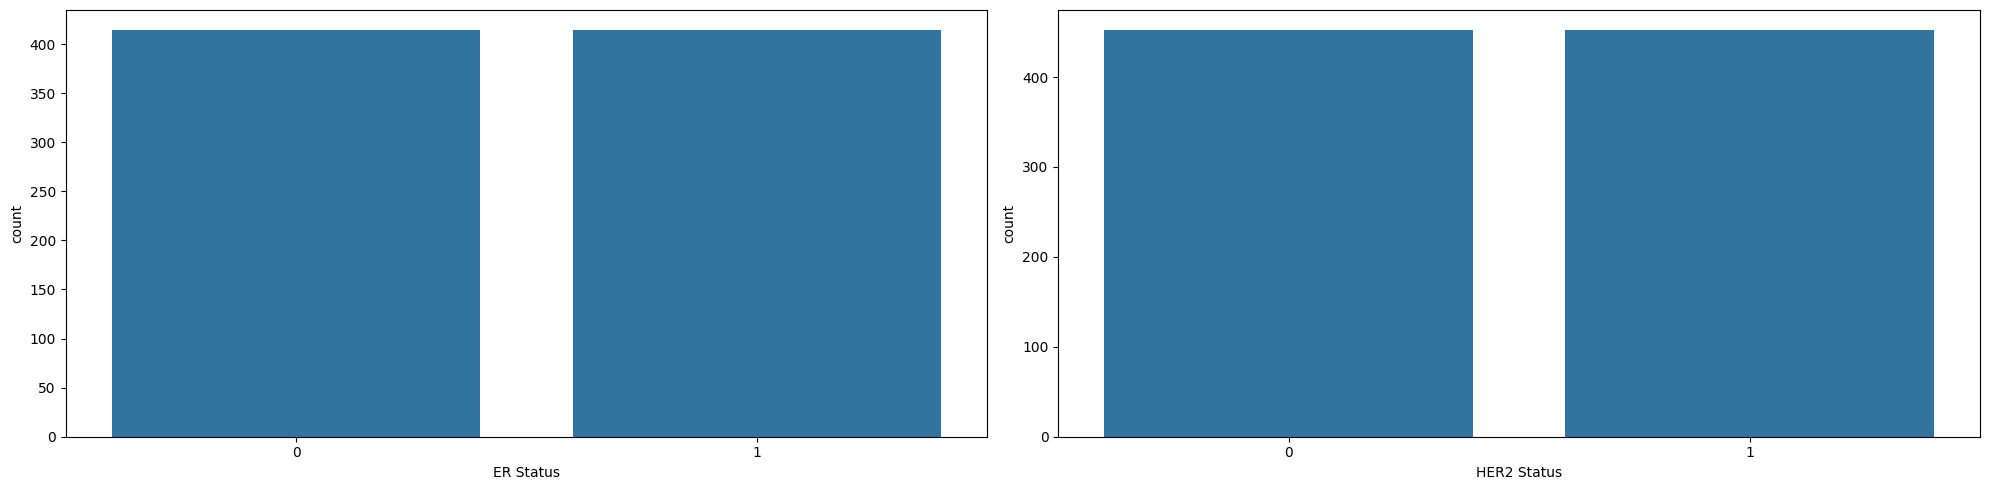

In [15]:
# Plotting the distribution of the resampled data

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=train_y_er, ax=axes[0])
axes[0].set_xlabel('ER Status')

sns.countplot(x=train_y_her2, ax=axes[1])
axes[1].set_xlabel('HER2 Status')

plt.tight_layout()
plt.show()

## Fitting models

In [16]:
classifications_classes = {
    'ER' : (train_x_er, train_y_er, val_x_er, val_y_er, test_x_er, test_y_er),
    'PR' : (train_x_pr, train_y_pr, val_x_pr, val_y_pr, test_x_pr, test_y_pr),
    'HER2': (train_x_her2, train_y_her2, val_x_her2, val_y_her2, test_x_her2, test_y_her2),
    'Mol Subtype': (train_x_mol_subtype, train_y_mol_subtype, val_x_mol_subtype, val_y_mol_subtype, test_x_mol_subtype, test_y_mol_subtype)
}

In [17]:
def get_metrics(model, x, truey, split):
    pred_y = model.predict(x)
    acc = accuracy_score(truey, pred_y)
    prec = precision_score(truey, pred_y, average = 'weighted')
    rec = recall_score(truey, pred_y, average = 'weighted')
    f1 = f1_score(truey, pred_y, average = 'weighted')

    return {f'{split}_acc': acc, f'{split}_prec': prec, f'{split}_rec': rec, f'{split}_f1': f1}


In [18]:
def get_NB_model(tx, ty, vx, vy, testx, testy, classification = None):
    nb = GaussianNB()
    nb.fit(tx, ty)
    
    train_metrics = get_metrics(nb, tx, ty, 'train')
    val_metrics = get_metrics(nb, vx, vy, 'val')
    test_metrics = get_metrics(nb, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Naive Bayes'
    if classification is not None:
        result['classification'] = classification

    return result, nb

def get_DT_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Decision Tree model with metrics'''
    model = decision_tree.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Decision Tree'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get KNN model with metrics'''
    model = k_nearest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'KNN'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_LR_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Logistic Regression model with metrics'''
    model = logistic_regression.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Logistic Regression'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_RF_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get Random forest model with metrics'''
    model = random_forest.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'Random Forest'
    if classification is not None:
        result['classification'] = classification

    return result, model

def get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get SVM model with metrics'''
    model = support_vector_cls.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'SVM'
    if classification is not None:
        result['classification'] = classification

    return result, model
    
def get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get XGBoost model with metrics'''
    model = xgboost.get_best_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **train_metrics}

    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'XGBoost'
    if classification is not None:
        result['classification'] = classification

    return result, model

In [19]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


def tune_catboost_hyperparameters(train_x, train_y, val_x, val_y, parameters = None, criterion = 'accuracy'):

    param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.1, 0.2, 0.25],
    'iterations': [150, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
    }

    if parameters is not None:
        param_grid = parameters
    
    split_index = [-1]*len(train_x) + [0]*len(val_x)
    X = np.concatenate((train_x, val_x), axis=0)
    y = np.concatenate((train_y, val_y), axis=0)
    pds = PredefinedSplit(test_fold = split_index)
    model = CatBoostClassifier()


    grid_search = GridSearchCV(model, param_grid = param_grid, cv = pds, scoring = criterion)
    grid_search.fit(X, y)  
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # print("Best Hyperparameters: ", best_params)
    # print("Best Score: ", best_model.score(val_x, val_y))
    return best_model

def get_catboost_model(tx, ty, vx, vy, testx, testy, criterion = 'accuracy', classification = None):
    '''Get CatBoost model with metrics'''
    model = tune_catboost_hyperparameters(tx, ty, vx, vy, criterion = criterion)

    train_metrics = get_metrics(model, tx, ty, 'train')
    val_metrics = get_metrics(model, vx, vy, 'val')
    test_metrics = get_metrics(model, testx, testy, 'test')

    combined_metrics = {**train_metrics, **val_metrics, **test_metrics}


    result = pd.DataFrame(combined_metrics, index = [0])
    result['Algorithm'] = 'CatBoost'
    if classification is not None:
        result['classification'] = classification

    return result, model

In [20]:
classification_results = pd.DataFrame()
models = {}


from sklearn.decomposition import PCA

for key, value in classifications_classes.items():

   tx, ty, vx, vy, testx, testy = value
    
   # Applying Feature Scaling to the data using the Standard Scaler
   scaler = Scaler()
   tx = scaler.fit_transform(tx)
   vx = scaler.transform(vx)
   testx = scaler.transform(testx)

   # Applying Principal Component Analysis to the data

   pca = PCA(n_components = 'mle', svd_solver = 'full')
   tx = pca.fit_transform(tx)
   vx = pca.transform(vx)
   testx = pca.transform(testx)
   
   
   res_nb, nb = get_NB_model(tx, ty, vx, vy, testx, testy, classification = key)
   res_dt, dt = get_DT_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_knn, knn = get_KNN_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_lr, lr = get_LR_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_rf, rf = get_RF_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_svm, svm = get_SVM_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_xgb, xgb = get_XGB_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   res_cat, cat = get_catboost_model(tx, ty, vx, vy, testx, testy, criterion = CRITERION, classification = key)
   

   models[key] = {'Naive Bayes' : nb,
                  'Decision Trees' : dt,
                  'K Nearest Neighbours': knn,
                  'Logistic Regression' : lr,
                  'Random Forest' : rf,
                  'SVM': svm,
                  'XGBoost': xgb,
                  'CatBoost': cat}
   
   classification_results = pd.concat([classification_results,
                                       res_nb,
                                       res_dt,
                                       res_knn,
                                       res_lr,
                                       res_rf,
                                       res_svm,
                                       res_xgb,
                                       res_cat])

/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn

0:	learn: 0.5768038	total: 92.1ms	remaining: 13.7s
1:	learn: 0.5233493	total: 114ms	remaining: 8.44s
2:	learn: 0.4618430	total: 141ms	remaining: 6.92s
3:	learn: 0.4122497	total: 159ms	remaining: 5.8s
4:	learn: 0.3498644	total: 184ms	remaining: 5.33s
5:	learn: 0.3056012	total: 201ms	remaining: 4.83s
6:	learn: 0.2717955	total: 234ms	remaining: 4.78s
7:	learn: 0.2480161	total: 251ms	remaining: 4.45s
8:	learn: 0.2277775	total: 278ms	remaining: 4.36s
9:	learn: 0.2102532	total: 300ms	remaining: 4.2s
10:	learn: 0.1960826	total: 347ms	remaining: 4.38s
11:	learn: 0.1770352	total: 365ms	remaining: 4.2s
12:	learn: 0.1649995	total: 389ms	remaining: 4.1s
13:	learn: 0.1564523	total: 410ms	remaining: 3.98s
14:	learn: 0.1480348	total: 436ms	remaining: 3.93s
15:	learn: 0.1387868	total: 458ms	remaining: 3.83s
16:	learn: 0.1322836	total: 488ms	remaining: 3.81s
17:	learn: 0.1271761	total: 511ms	remaining: 3.74s
18:	learn: 0.1214837	total: 531ms	remaining: 3.66s
19:	learn: 0.1154098	total: 563ms	remaining:

/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn

0:	learn: 0.6351925	total: 96.6ms	remaining: 14.4s
1:	learn: 0.5770436	total: 157ms	remaining: 11.6s
2:	learn: 0.5422514	total: 229ms	remaining: 11.2s
3:	learn: 0.5047417	total: 312ms	remaining: 11.4s
4:	learn: 0.4646591	total: 502ms	remaining: 14.6s
5:	learn: 0.4336673	total: 572ms	remaining: 13.7s
6:	learn: 0.4071360	total: 657ms	remaining: 13.4s
7:	learn: 0.3909635	total: 787ms	remaining: 14s
8:	learn: 0.3770755	total: 867ms	remaining: 13.6s
9:	learn: 0.3623072	total: 978ms	remaining: 13.7s
10:	learn: 0.3482054	total: 1.24s	remaining: 15.7s
11:	learn: 0.3374026	total: 1.39s	remaining: 16s
12:	learn: 0.3254014	total: 1.49s	remaining: 15.7s
13:	learn: 0.3139249	total: 1.59s	remaining: 15.5s
14:	learn: 0.3025065	total: 1.7s	remaining: 15.3s
15:	learn: 0.2945664	total: 1.79s	remaining: 15s
16:	learn: 0.2870438	total: 1.85s	remaining: 14.5s
17:	learn: 0.2751938	total: 1.9s	remaining: 13.9s
18:	learn: 0.2666106	total: 1.96s	remaining: 13.5s
19:	learn: 0.2608677	total: 2.03s	remaining: 13.

/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn

0:	learn: 0.6246449	total: 63ms	remaining: 9.38s
1:	learn: 0.5623646	total: 149ms	remaining: 11s
2:	learn: 0.5299508	total: 216ms	remaining: 10.6s
3:	learn: 0.5005316	total: 306ms	remaining: 11.2s
4:	learn: 0.4479633	total: 399ms	remaining: 11.6s
5:	learn: 0.4142459	total: 461ms	remaining: 11.1s
6:	learn: 0.3499650	total: 543ms	remaining: 11.1s
7:	learn: 0.3217475	total: 584ms	remaining: 10.4s
8:	learn: 0.3043503	total: 608ms	remaining: 9.53s
9:	learn: 0.2767291	total: 709ms	remaining: 9.93s
10:	learn: 0.2569781	total: 877ms	remaining: 11.1s
11:	learn: 0.2340597	total: 983ms	remaining: 11.3s
12:	learn: 0.2282569	total: 1.06s	remaining: 11.2s
13:	learn: 0.2224396	total: 1.21s	remaining: 11.7s
14:	learn: 0.2113592	total: 1.4s	remaining: 12.6s
15:	learn: 0.1940305	total: 1.46s	remaining: 12.2s
16:	learn: 0.1888507	total: 1.52s	remaining: 11.9s
17:	learn: 0.1752867	total: 1.56s	remaining: 11.5s
18:	learn: 0.1709606	total: 1.64s	remaining: 11.3s
19:	learn: 0.1656892	total: 1.69s	remaining: 

/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ayushsharma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0:	learn: 1.2217207	total: 159ms	remaining: 23.6s
1:	learn: 1.0971325	total: 358ms	remaining: 26.5s
2:	learn: 0.9879070	total: 558ms	remaining: 27.3s
3:	learn: 0.9002109	total: 818ms	remaining: 29.9s
4:	learn: 0.8148785	total: 1.06s	remaining: 30.6s
5:	learn: 0.7407596	total: 1.33s	remaining: 31.9s
6:	learn: 0.6912195	total: 1.5s	remaining: 30.6s
7:	learn: 0.6323953	total: 1.64s	remaining: 29s
8:	learn: 0.5879253	total: 1.74s	remaining: 27.2s
9:	learn: 0.5489106	total: 1.97s	remaining: 27.6s
10:	learn: 0.5157014	total: 2.22s	remaining: 28s
11:	learn: 0.4771691	total: 2.37s	remaining: 27.2s
12:	learn: 0.4440172	total: 2.61s	remaining: 27.5s
13:	learn: 0.4178332	total: 2.75s	remaining: 26.7s
14:	learn: 0.3877886	total: 2.87s	remaining: 25.8s
15:	learn: 0.3673099	total: 3.07s	remaining: 25.7s
16:	learn: 0.3421214	total: 3.17s	remaining: 24.8s
17:	learn: 0.3223692	total: 3.34s	remaining: 24.5s
18:	learn: 0.3029760	total: 3.51s	remaining: 24.2s
19:	learn: 0.2829340	total: 3.67s	remaining: 2

In [24]:
# RESULTS_PATH = f'Results_NoResample/55_15_30_Scaling_PCA_{FILENAME}.csv'

# MODEL_PICKLING = f'Results_NoResample/55_15_30_Models_Scaling_PCA_{FILENAME}.pkl'

cols = classification_results.columns.tolist()
cols = cols[-2:] + cols[:-2]
classification_results = classification_results[cols]

classification_results.to_csv("Results_catboost.csv",index = False)

with open("models_catboost", 'wb') as file:
    pkl.dump(models, file)

In [30]:
models

{'ER': {'Naive Bayes': GaussianNB(),
  'Decision Trees': DecisionTreeClassifier(max_depth=5, min_samples_split=4),
  'K Nearest Neighbours': KNeighborsClassifier(n_neighbors=11),
  'Logistic Regression': LogisticRegression(C=1, solver='liblinear'),
  'Random Forest': RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200),
  'SVM': SVC(C=10, gamma='auto'),
  'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=20,
                min_child_weight=None, missing=n

In [37]:
models['Mol Subtype']['CatBoost'].get_params()

{'depth': 6, 'iterations': 150, 'l2_leaf_reg': 5, 'learning_rate': 0.2}

In [43]:
len(classifications_classes['ER'])
ER_trainX = classifications_classes['ER'][0]
ER_trainY = classifications_classes['ER'][1]
ER_valX = classifications_classes['ER'][2]
ER_valY = classifications_classes['ER'][3]
ER_testX = classifications_classes['ER'][4]
ER_testY = classifications_classes['ER'][5]

In [44]:
# Check for common entries between train and validation sets
common_entries_train_val = pd.merge(ER_trainX, ER_valX, how='inner')
print("\nCommon entries between train and validation sets:")
print(common_entries_train_val)

# Check for common entries between train and test sets
common_entries_train_test = pd.merge(ER_trainX, ER_testX, how='inner')
print("\nCommon entries between train and test sets:")
print(common_entries_train_test)

# Check for common entries between validation and test sets
common_entries_val_test = pd.merge(ER_valX, ER_testX, how='inner')
print("\nCommon entries between validation and test sets:")
print(common_entries_val_test)



Common entries between train and validation sets:
Empty DataFrame
Columns: [original_shape_Elongation, original_shape_Flatness, original_shape_LeastAxisLength, original_shape_MajorAxisLength, original_shape_Maximum2DDiameterColumn, original_shape_Maximum2DDiameterRow, original_shape_Maximum2DDiameterSlice, original_shape_Maximum3DDiameter, original_shape_MeshVolume, original_shape_MinorAxisLength, original_shape_Sphericity, original_shape_SurfaceArea, original_shape_SurfaceVolumeRatio, original_shape_VoxelVolume, original_firstorder_10Percentile, original_firstorder_90Percentile, original_firstorder_Energy, original_firstorder_Entropy, original_firstorder_InterquartileRange, original_firstorder_Kurtosis, original_firstorder_Maximum, original_firstorder_MeanAbsoluteDeviation, original_firstorder_Mean, original_firstorder_Median, original_firstorder_Minimum, original_firstorder_Range, original_firstorder_RobustMeanAbsoluteDeviation, original_firstorder_RootMeanSquared, original_firstord


Common entries between train and test sets:
Empty DataFrame
Columns: [original_shape_Elongation, original_shape_Flatness, original_shape_LeastAxisLength, original_shape_MajorAxisLength, original_shape_Maximum2DDiameterColumn, original_shape_Maximum2DDiameterRow, original_shape_Maximum2DDiameterSlice, original_shape_Maximum3DDiameter, original_shape_MeshVolume, original_shape_MinorAxisLength, original_shape_Sphericity, original_shape_SurfaceArea, original_shape_SurfaceVolumeRatio, original_shape_VoxelVolume, original_firstorder_10Percentile, original_firstorder_90Percentile, original_firstorder_Energy, original_firstorder_Entropy, original_firstorder_InterquartileRange, original_firstorder_Kurtosis, original_firstorder_Maximum, original_firstorder_MeanAbsoluteDeviation, original_firstorder_Mean, original_firstorder_Median, original_firstorder_Minimum, original_firstorder_Range, original_firstorder_RobustMeanAbsoluteDeviation, original_firstorder_RootMeanSquared, original_firstorder_Ske

In [50]:
from sklearn.model_selection import cross_val_score

# Use cross-validation to estimate validation loss on different data splits.
scores = cross_val_score(models['Mol Subtype']['SVM'], vx, vy, cv=5, scoring="neg_mean_squared_error")
print(f"Mean validation loss: {np.mean(scores)}")

Mean validation loss: -0.3791005291005291
